In [1]:
!python3 --version

Python 3.10.13


In [3]:
import pandas as pd
from random import seed

seed(42)

price_df = pd.read_csv(f"~/git/tmp/data/twlo_prices.csv")

price_df.head()

,close,volume,date
0,99.98,93417.0,2020-01-02 14:30:00+00:00
1,99.78,16685.0,2020-01-02 14:31:00+00:00
2,100.14,21998.0,2020-01-02 14:32:00+00:00
3,100.35,18348.0,2020-01-02 14:33:00+00:00
4,100.55,22181.0,2020-01-02 14:34:00+00:00


In [4]:
price_df.index = pd.to_datetime(price_df['date'])
price_df.index = price_df.index.tz_convert('US/Pacific')

price_df.sort_index(inplace=True)

del price_df['date']

price_df.head()

,close,volume
date,,
2020-01-02 06:30:00-08:00,99.98,93417.0
2020-01-02 06:31:00-08:00,99.78,16685.0
2020-01-02 06:32:00-08:00,100.14,21998.0
2020-01-02 06:33:00-08:00,100.35,18348.0
2020-01-02 06:34:00-08:00,100.55,22181.0


Matplotlib is building the font cache; this may take a moment.


<Axes: xlabel='date'>

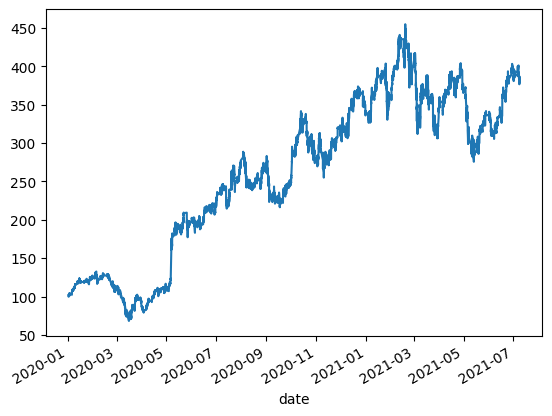

In [6]:
price_df['close'].plot()

In [7]:
# その日の終値
last_price_of_the_day = price_df.groupby(price_df.index.date).tail(1)['close'].rename('day_close_price')
last_price_of_the_day.index = last_price_of_the_day.index.date

price_df['day'] = price_df.index.date

# price_dfの日付とlast_price_of_the_dayのindexで結合
price_df = price_df.merge(last_price_of_the_day, left_on='day', right_index=True)

# 終値までの変化率
price_df['pct_change_eod'] = (price_df['day_close_price'] - price_df['close']) / price_df['close']

# 2値の応答変数列
price_df['stock_price_rose'] = price_df['pct_change_eod'] > 0

price_df.head()

,close,volume,day,day_close_price,pct_change_eod,stock_price_rose
date,,,,,,
2020-01-02 06:30:00-08:00,99.98,93417.0,2020-01-02,103.15,0.031706,True
2020-01-02 06:31:00-08:00,99.78,16685.0,2020-01-02,103.15,0.033774,True
2020-01-02 06:32:00-08:00,100.14,21998.0,2020-01-02,103.15,0.030058,True
2020-01-02 06:33:00-08:00,100.35,18348.0,2020-01-02,103.15,0.027902,True
2020-01-02 06:34:00-08:00,100.55,22181.0,2020-01-02,103.15,0.025858,True


In [ ]:
#
# 特徴量作成
#

In [8]:
# 日付・時刻特徴量

# 曜日（順序尺度）
price_df['feature__dayofweek'] = price_df.index.dayofweek
# 午前（名義尺度）
price_df['feature__morning'] = price_df.index.hour < 12

Text(0.5, 0, 'Day of the Week')

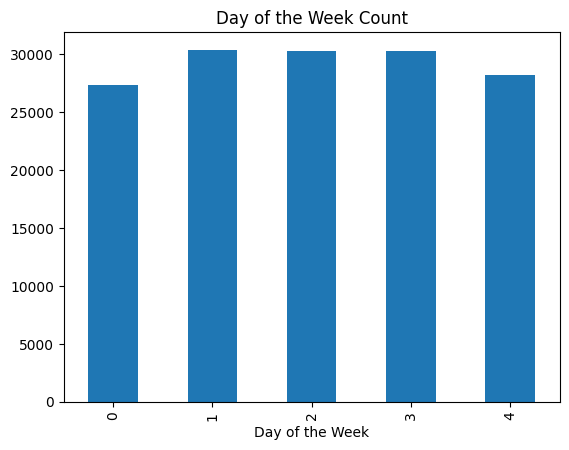

In [9]:
import matplotlib.pyplot as plt

# 月・金の休み
price_df['feature__dayofweek'].value_counts().sort_index().plot(kind='bar', title='Day of the Week Count')
plt.xlabel('Day of the Week')

Text(0.5, 0, 'Is Morning')

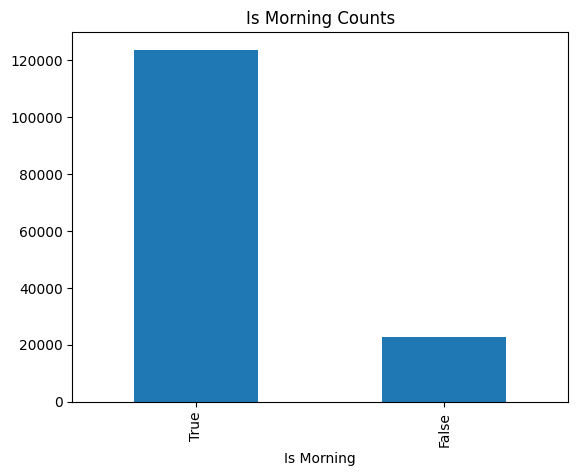

In [10]:
# 午前のほうが多い
price_df['feature__morning'].value_counts().plot(kind='bar', title='Is Morning Counts')
plt.xlabel('Is Morning')

/var/folders/bk/nnrs019x61jgp6ty0k468bgm0000gn/T/ipykernel_47244/474051424.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  price_df['feature__lag_30_min_ago_price'] = price_df['close'].shift(30, freq='T')


Text(0, 0.5, 'Price')

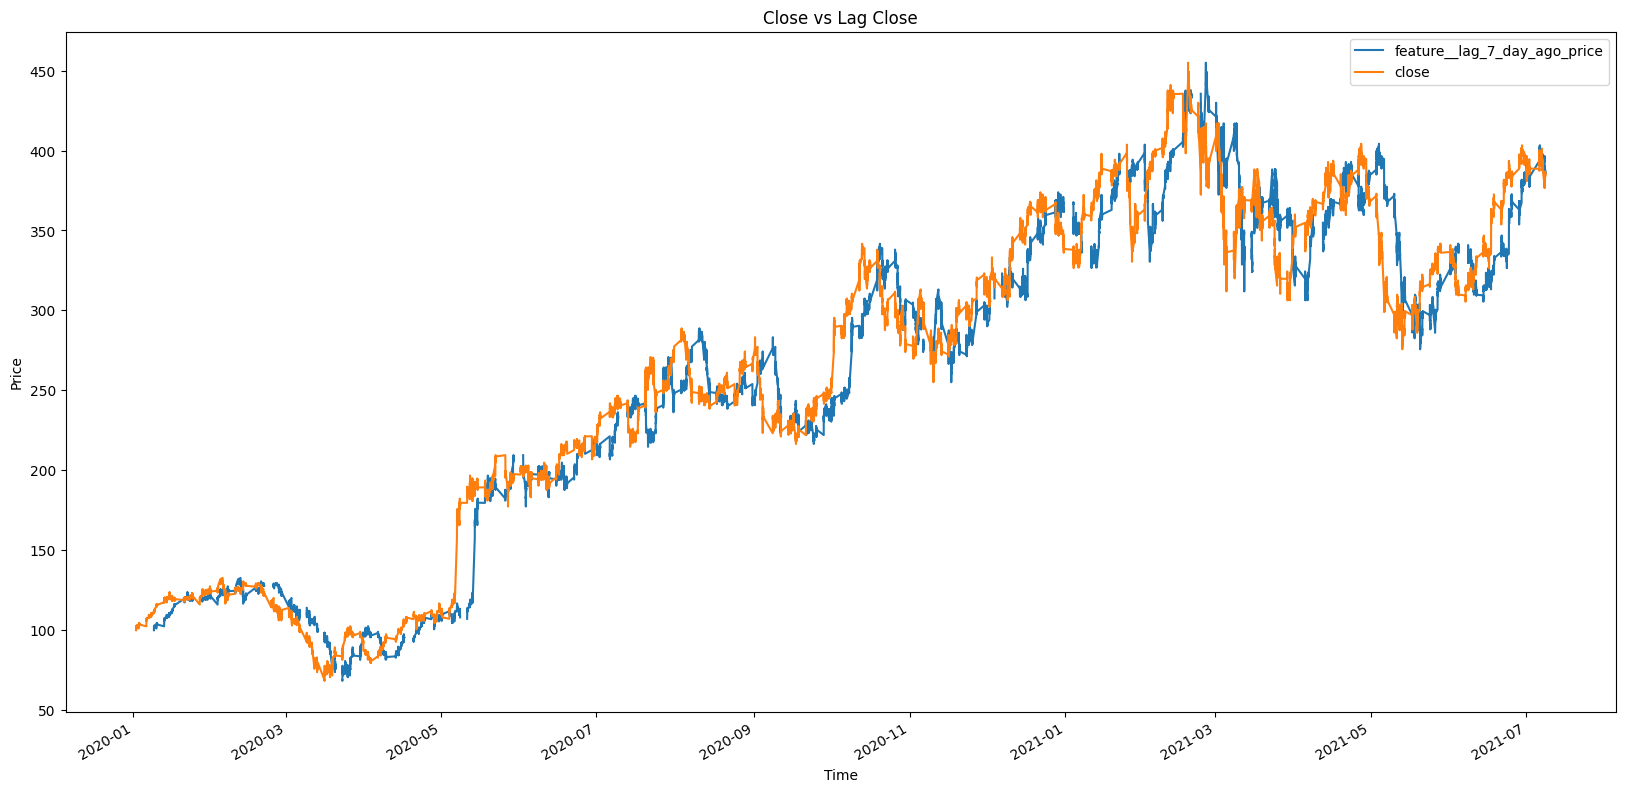

In [11]:
# ラグ特徴量

# 30分前
price_df['feature__lag_30_min_ago_price'] = price_df['close'].shift(30, freq='T')
# 7日前
price_df['feature__lag_7_day_ago_price'] = price_df['close'].shift(7, freq='D')

price_df['feature__lag_7_day_ago_price'].plot(figsize=(20,10), title='Close vs Lag Close')
price_df['close'].plot()
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')

In [12]:
# ローリング特徴量

# 株価のローリング60分平均
price_df['feature__rolling_close_mean_60'] = price_df['close'].rolling('60min').mean()
# 株価のローリング60分標準偏差
price_df['feature__rolling_close_std_60'] = price_df['close'].rolling('60min').std()
# 出来高のローリング60分平均
price_df['feature__rolling_volume_mean_60'] = price_df['volume'].rolling('60min').mean()
# 出来高のローリング60分標準偏差
price_df['feature__rolling_volume_std_60'] = price_df['volume'].rolling('60min').std()

In [13]:
# エクスパディング特徴量

# 最小200分の株価のエクスパディング平均
price_df['feature__expanding_close_mean'] = price_df['close'].expanding(200).mean()
# 最小200分の出来高のエクスパディング平均
price_df['feature__expanding_volume_mean'] = price_df['volume'].expanding(200).mean()

In [14]:
# 欠損値のある行を削除
price_df.dropna(inplace=True)

Text(0, 0.5, 'Price')

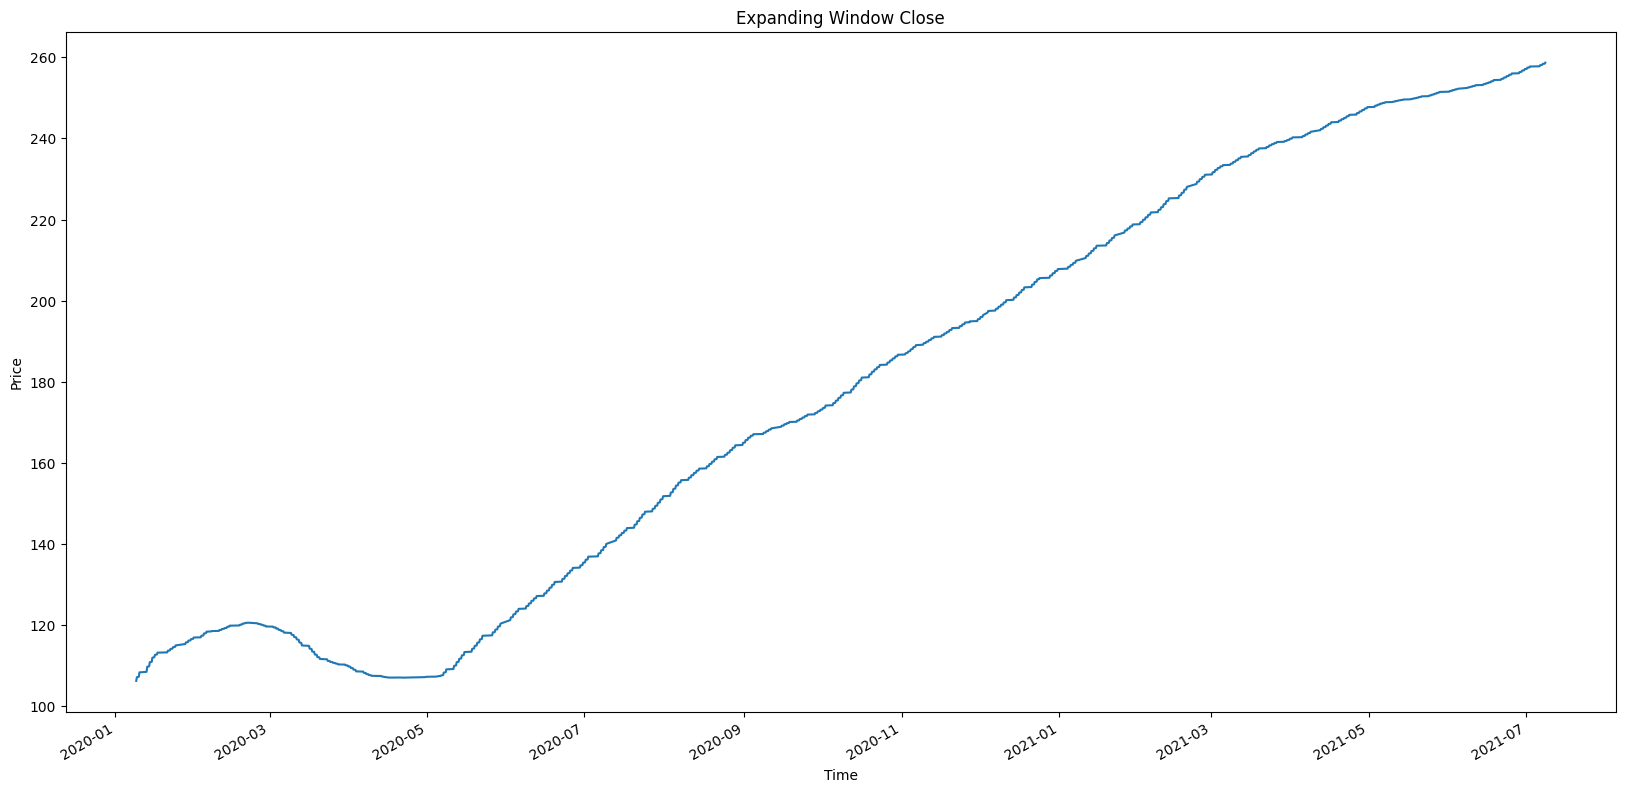

In [15]:
price_df['feature__expanding_close_mean'].plot(figsize=(20, 10), title='Expanding Window Close')

plt.xlabel('Time')
plt.ylabel('Price')

Text(0, 0.5, 'Shares')

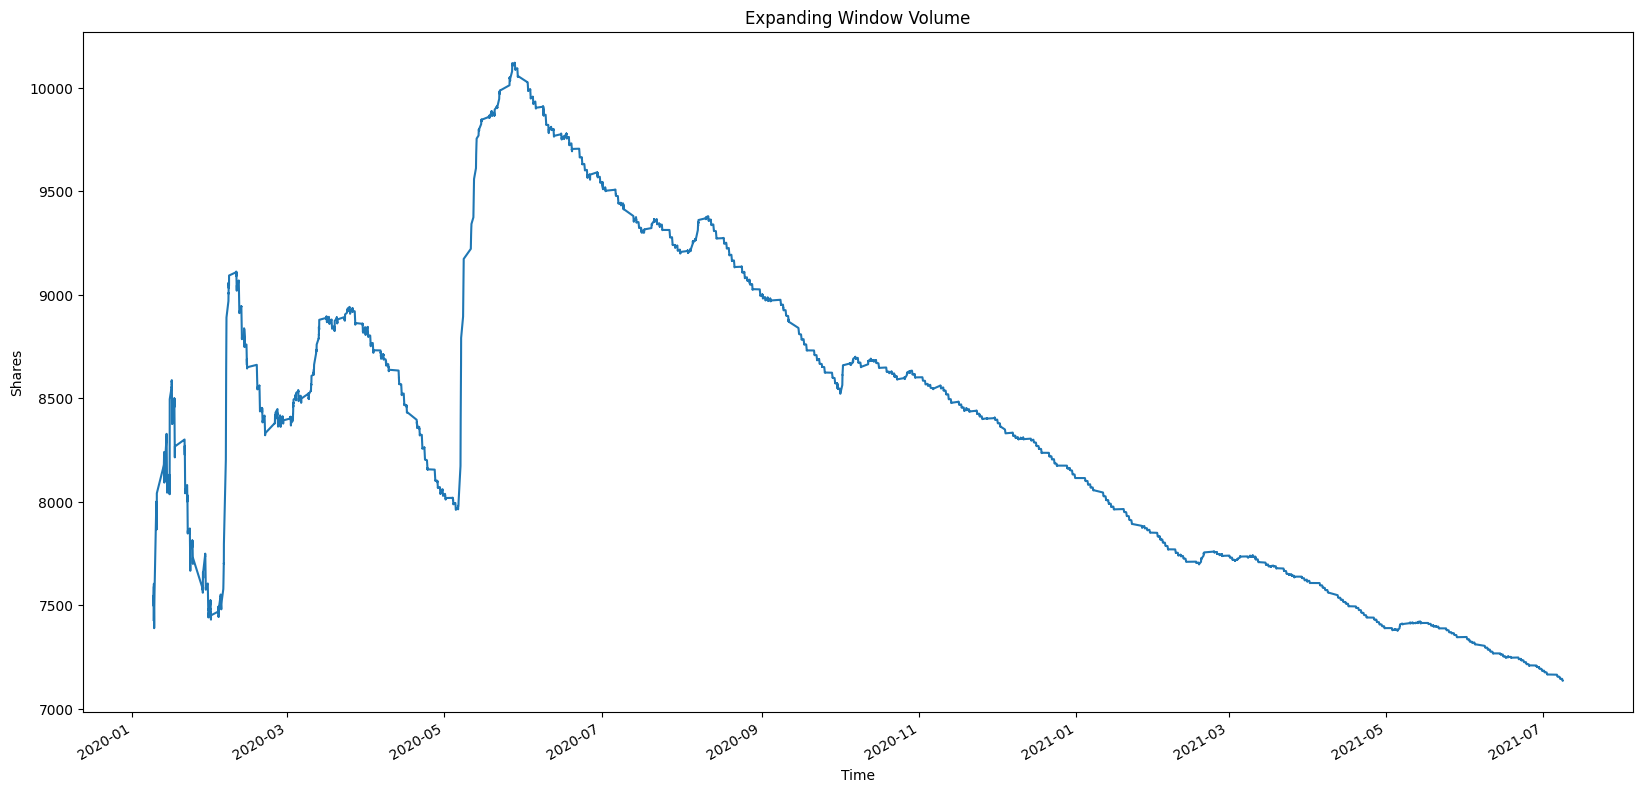

In [16]:
price_df['feature__expanding_volume_mean'].plot(figsize=(20, 10), title='Expanding Window Volume')  # A

plt.xlabel('Time')
plt.ylabel('Shares')

In [19]:
import numpy as np
np.random.seed(0)
import random
random.seed(0)

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.pipeline import Pipeline
import time

def advanced_grid_search(x_train, y_train, x_test, y_test, ml_pipeline, params, cv=3, include_probas=False, is_regression=False):
    '''
    This helper function will grid search a machine learning pipeline with feature engineering included
    and print out a classification report for the best param set.
    Best here is defined as having the best cross-validated accuracy on the training set
    '''

    model_grid_search = GridSearchCV(ml_pipeline, param_grid=params, cv=cv, error_score=-1)
    start_time = time.time()  # capture the start time

    model_grid_search.fit(x_train, y_train)

    best_model = model_grid_search.best_estimator_

    y_preds = best_model.predict(x_test)

    if is_regression:
        rmse = np.sqrt(mean_squared_error(y_pred=y_preds, y_true=test_set['pct_change_eod']))
        print(f'RMSE: {rmse:.5f}')
    else:
        print(classification_report(y_true=y_test, y_pred=y_preds))
    print(f'Best params: {model_grid_search.best_params_}')
    end_time = time.time()
    print(f"Overall took {(end_time - start_time):.2f} seconds")

    if include_probas:
        y_probas = best_model.predict_proba(x_test).max(axis=1)
        return best_model, y_preds, y_probas

    return best_model, y_preds

In [20]:
# ベースライン特徴量の作成

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

clf = RandomForestClassifier(random_state=0)

ml_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('classifier', clf)
])

params = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__min_samples_split': [2, 3, 5],
    
    'classifier__max_depth': [10, None],
    'classifier__max_features': [None, 'auto']
}

In [21]:
from sklearn.model_selection import TimeSeriesSplit

# 訓練データが5つ、検証データを合わせると6分割
tscv = TimeSeriesSplit(n_splits=5)

# 書籍ではn_splits=2
# tscv = TimeSeriesSplit(n_splits=2)

In [22]:
# 訓練データの期間が長くなる
# 訓練:検証
# 1:1〜5:1
for i, (train_index, test_index) in enumerate(tscv.split(price_df)):
    train_times, test_times = price_df.iloc[train_index].index, price_df.iloc[test_index].index

    print(f'Iteration {i}\n-------------')
    print(f'''Training between {train_times.min().date()} and {train_times.max().date()}. Testing between {test_times.min().date()} and {test_times.max().date()}\n''')

Iteration 0
-------------
Training between 2020-01-09 and 2020-04-06. Testing between 2020-04-06 and 2020-07-01

Iteration 1
-------------
Training between 2020-01-09 and 2020-07-01. Testing between 2020-07-01 and 2020-09-25

Iteration 2
-------------
Training between 2020-01-09 and 2020-09-25. Testing between 2020-09-25 and 2020-12-22

Iteration 3
-------------
Training between 2020-01-09 and 2020-12-22. Testing between 2020-12-22 and 2021-03-30

Iteration 4
-------------
Training between 2020-01-09 and 2021-03-30. Testing between 2021-03-30 and 2021-07-08



In [23]:
def split_data(price_df):
    # 0分（時間足）に再サンプリング
    downsized_price_df = price_df[(price_df.index.minute == 0)]
    # 2021-06-01以降をテストデータに分割
    train_df, test_df = downsized_price_df[:'2021-05-31'], downsized_price_df['2021-06-01':]
    # 特徴量
    train_X, test_X = train_df.filter(regex='feature'), test_df.filter(regex='feature')
    # 応答変数
    train_y, test_y = train_df['stock_price_rose'], test_df['stock_price_rose']

    return train_df, test_df, train_X, train_y, test_X, test_y

In [24]:
train_df, test_df, train_X, train_y, test_X, test_y = split_data(price_df)

In [25]:
# 最初のベースラインモデル
print("Date-time/Lag/Window/Rolling features + Random Forest\n==========================")
best_model, test_preds, test_probas = advanced_grid_search(
    train_X, train_y,
    test_X, test_y,
    ml_pipeline, params, 
    cv=tscv, include_probas=True  # C
)

# null正解率は48%
test_y.value_counts(normalize=True) 

Date-time/Lag/Window/Rolling features + Random Forest


/Users/tshinkura/git/python/notebooks/uv-test/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to -1.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/tshinkura/git/python/notebooks/uv-test/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tshinkura/git/python/notebooks/uv-test/.venv/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/tshinkura/git/python/notebooks/uv-test/.

              precision    recall  f1-score   support

       False       0.54      0.88      0.67        72
        True       0.62      0.22      0.32        69

    accuracy                           0.55       141
   macro avg       0.58      0.55      0.49       141
weighted avg       0.58      0.55      0.50       141

Best params: {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__max_features': None, 'classifier__min_samples_split': 3}
Overall took 29.50 seconds


stock_price_rose
False    0.510638
True     0.489362
Name: proportion, dtype: float64